## Random Forest
Random forest is a supervised algorithm that uses an ensemble learning method consisting of decision trees, the output of which is the consensus of the best answer to the problem. Decision trees arrive at an answer by asking a series of true/false questions about elements in a data set. The presence of a large number of trees also reduces the problem of overfitting, which occurs when a model incorporates too much “noise” in the training data and makes poor decisions as a result. Random Forest can be used for classification, thus can predict whether a user will be active or not. 

### 1. Imports

In [15]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
)
from joblib import Memory
from scipy.stats import randint, uniform
import shap
import json
import os


### 2. Loading data

In [16]:
df = pd.read_csv("../data/user_level_data.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:\n{df['y_active'].value_counts()}")
print(f"Class balance: {df['y_active'].value_counts(normalize=True)}")

Dataset shape: (20011, 31)

Target variable distribution:
y_active
0    14284
1     5727
Name: count, dtype: int64
Class balance: y_active
0    0.713807
1    0.286193
Name: proportion, dtype: float64


### 3. Preprocessing

In [17]:
# Drop id column
id_columns = ["userId"]
target = "y_active"
columns_to_drop = [target] + [c for c in id_columns if c in df.columns]
print(f"\nDropping ID columns: {[c for c in id_columns if c in df.columns]}")
X_raw = df.drop(columns=columns_to_drop, errors="ignore")

# Set target variable
y = df["y_active"].astype(int)

# Identify numerical and categorical features
num_cols = selector(dtype_include=np.number)(X_raw)
cat_cols = [c for c in X_raw.columns if c not in num_cols]

print(f"\nNumeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")

# Preprocessing pipelines
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size:     {X_test.shape}")

# Model Pipeline with Caching
cache = Memory(location="cache_rf", verbose=0)
rf = RandomForestClassifier(
    n_jobs=-1,
    bootstrap=True,            # required for max_samples
    class_weight="balanced",   # helpful for imbalanced
    random_state=42
)
pipe = Pipeline([("prep", preprocess), ("rf", rf)], memory=cache)



Dropping ID columns: ['userId']

Numeric features: 28
Categorical features: 1

Training set size: (16008, 29)
Test set size:     (4003, 29)


### 4. Hyperparameter Tuning

In [18]:
param_dist = {
    "rf__n_estimators": randint(300, 800),
    "rf__max_depth": [8, 12, 16, 20, None],
    "rf__min_samples_split": randint(8, 25),
    "rf__min_samples_leaf": randint(4, 12),
    "rf__max_features": ["sqrt", 0.4, 0.5],
    "rf__max_samples": uniform(0.7, 0.25) 
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,                  
    cv=3,                      
    scoring="roc_auc",        
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=False
)

print("\nRunning RandomizedSearchCV...")
search.fit(X_train, y_train)

print("\nBest Parameters:", search.best_params_)
print("Best CV ROC-AUC:", f"{search.best_score_:.4f}")



Running RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters: {'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__max_samples': 0.8478244469269317, 'rf__min_samples_leaf': 9, 'rf__min_samples_split': 10, 'rf__n_estimators': 748}
Best CV ROC-AUC: 0.9536


### 5. Fit model with best parameters

In [19]:
# Fit model with best parameters
best_model = search.best_estimator_
# Fit with n_estimators increased to 1000
best_model.set_params(rf__n_estimators=730)
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("\nModel predictions completed.")


Model predictions completed.


### 6. Evaluation


MODEL PERFORMANCE METRICS

Classification Report:

Accuracy: 0.9031
              precision    recall  f1-score   support

           0     0.9885    0.8743    0.9279      2857
           1     0.7568    0.9747    0.8520      1146

    accuracy                         0.9031      4003
   macro avg     0.8726    0.9245    0.8900      4003
weighted avg     0.9222    0.9031    0.9062      4003



Confusion Matrix:
[[2498  359]
 [  29 1117]]


ROC-AUC Score and Curve:

ROC-AUC Score: 0.9571
PR-AUC Score: 0.8706
F1 Score (weighted): 0.9062


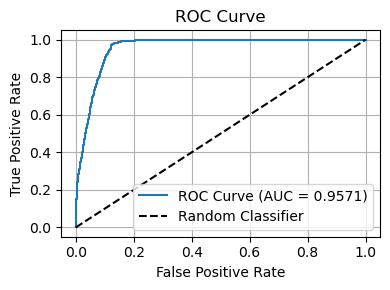



Precision-Recall Curve:


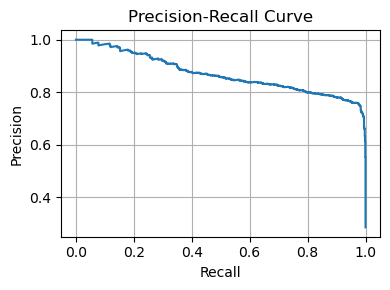

In [20]:

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print("\nClassification Report:")
# Classification report
accuracy  = accuracy_score(y_test, y_pred)
prec_score  = precision_score(y_test, y_pred, average="weighted")
rec_score   = recall_score(y_test, y_pred, average="weighted")
f1        = f1_score(y_test, y_pred, average="weighted")
roc_auc   = roc_auc_score(y_test, y_pred_proba)
pr_auc    = average_precision_score(y_test, y_pred_proba)

print(f"\nAccuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, digits=4))

print("\n" + "="*60)
print("\nConfusion Matrix:")
# Confusion matrix
print(confusion_matrix(y_test, y_pred))

print("\n" + "="*60)
print("\nROC-AUC Score and Curve:")
# ROC-AUC Score and Curve
try:
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
except Exception:
    print("\nROC-AUC Score: Not available")

print(f"PR-AUC Score: {pr_auc:.4f}")

print(f"F1 Score (weighted): {f1:.4f}")
fig1, ax1 = plt.subplots(figsize=(4, 3))
try:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True)
except Exception:
    ax1.text(0.5, 0.5, 'ROC Curve not available', ha='center', va='center')
plt.tight_layout()
plt.show()
# Precision-Recall Curve
fig, axes = plt.subplots(figsize=(4, 3))
try:
    print("\n" + "="*60)
    print("\nPrecision-Recall Curve:")
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes.plot(recall, precision)
    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision-Recall Curve')
    axes.grid(True)
except Exception:
    axes.text(0.5, 0.5, 'Precision-Recall Curve not available', ha='center', va='center')
plt.tight_layout()
plt.show()

# Saving metrics to JSON
rf_scores = {
    "roc_auc":   float(roc_auc),
    "pr_auc":    float(pr_auc),
    "precision": float(prec_score),
    "recall":    float(rec_score),
    "f1":        float(f1)
}

scores_path = "final_scores.json"

if os.path.exists(scores_path):
    with open(scores_path, "r") as f:
        all_scores = json.load(f)
else:
    all_scores = {}

all_scores["RandomForest"] = rf_scores

with open(scores_path, "w") as f:
    json.dump(all_scores, f, indent=2)

### 7. Feature Importances



Feature importance:
entropy_pca: 0.5560
usr_only_click: 0.1732
usr_action_rate: 0.0486
usr_avg_dwell: 0.0475
usr_engagement_span: 0.0240
usr_active_days: 0.0238
usr_avg_position: 0.0153
avg_pop_index_pca: 0.0150
usr_like_rate: 0.0144
avg_content_pop_index: 0.0137
avg_publishTime: 0.0127
avg_pop_rank_exposure_row: 0.0123
usr_sum_isLike_x_followlog: 0.0104
usr_followlog_x_actionrate: 0.0103
max_creator_pop_index: 0.0094
province: 0.0068
followCnt_log: 0.0021
usr_ever_inthomeviewed: 0.0021
usr_weekend_share: 0.0019
usr_shares_per_exp_follow: 0.0002
usr_share_rate: 0.0001
usr_ever_shared: 0.0001
age_gender_missing: 0.0001
usr_comment_rate: 0.0000
usr_intohome_x_liked: 0.0000
usr_ever_commented: 0.0000
usr_sum_isComment_x_followlog: 0.0000
usr_shared_x_liked: 0.0000
usr_shared_x_commented: 0.0000


Feature importance (SHAP values):


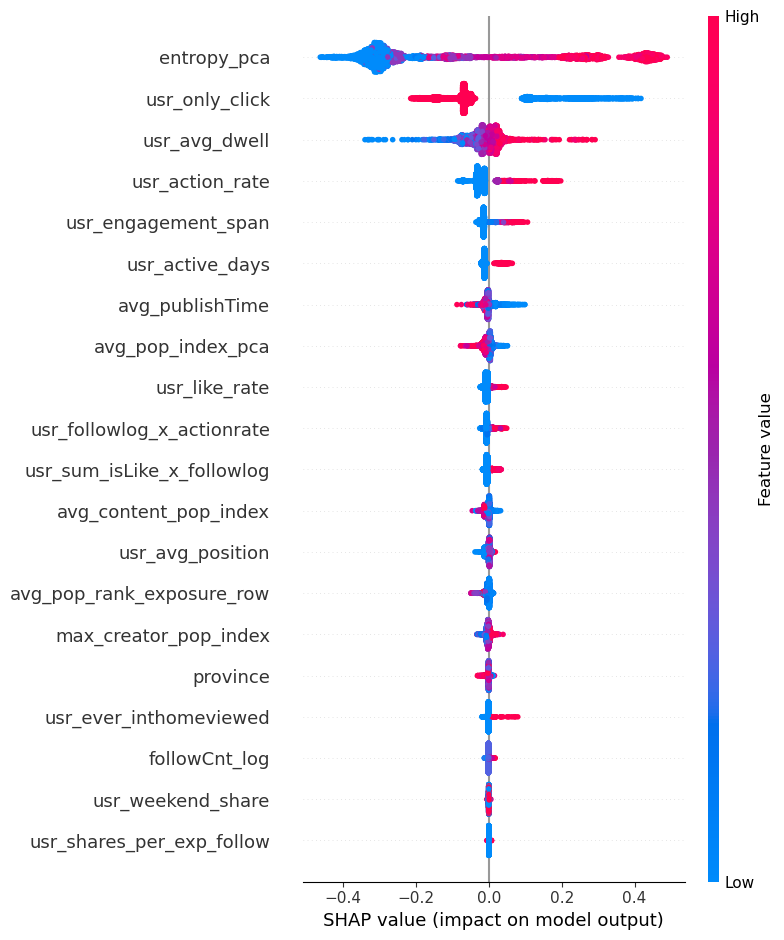

In [21]:
print("\n" + "="*60)
print("\nFeature importance:")
# Feature importance
importances = best_model.named_steps["rf"].feature_importances_
prep = best_model.named_steps["prep"]
feature_names = list(num_cols) + list(cat_cols)
indices = np.argsort(importances)[::-1]
for idx in indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

    
print("\n" + "="*60)
print("\nFeature importance (SHAP values):")
# Feature importance (SHAP values)

prep = best_model.named_steps["prep"]
rf   = best_model.named_steps["rf"]

X_test_t = prep.transform(X_test)

explainer = shap.TreeExplainer(rf)
shap_values_all = explainer.shap_values(X_test_t)  
shap_values_pos = shap_values_all[:, :, 1]        
feature_names = list(num_cols) + list(cat_cols)

shap.summary_plot(
    shap_values_pos,
    features=X_test_t,
    feature_names=feature_names,
    plot_type="dot",
    max_display=20
)

In [22]:
 
# Saving metrics to JSON
rf_scores = {
    "accuracy":  float(accuracy),
    "roc_auc":   float(roc_auc),
    "pr_auc":    float(pr_auc),
    "precision": float(prec_score),
    "recall":    float(rec_score),
    "f1":        float(f1)
}
 
scores_path = "final_scores.json"
 
if os.path.exists(scores_path):
    with open(scores_path, "r") as f:
        all_scores = json.load(f)
else:
    all_scores = {}
 
all_scores["RandomForest"] = rf_scores
 
with open(scores_path, "w") as f:
    json.dump(all_scores, f, indent=2)